In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import transformers

In [2]:
from src/BBPE_flores import build_gpt_tokenizer

## Load FLORES dataset

In [3]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'bo', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [4]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [5]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [6]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    plt.xticks(rotation=90)
    plt.ylabel("Line avg.")
    if title:
        plt.title(title)
    plt.show()

In [7]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

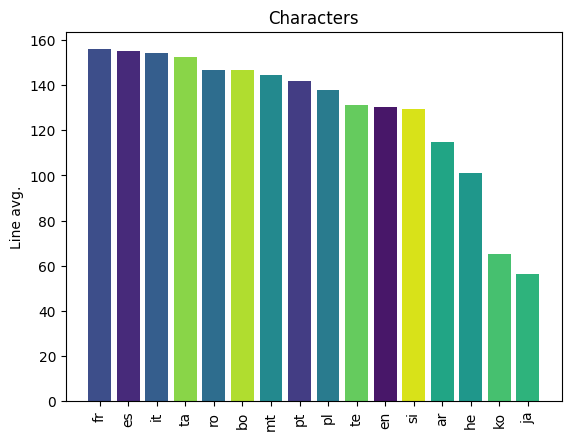

In [8]:
plot_token_numbers(flores_chars, "Characters")

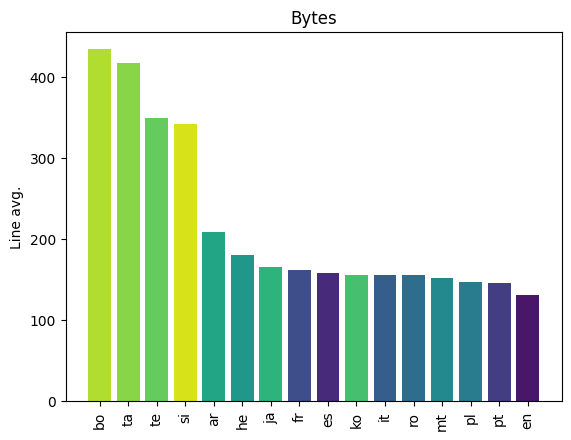

In [9]:
plot_token_numbers(flores_bytes, "Bytes")

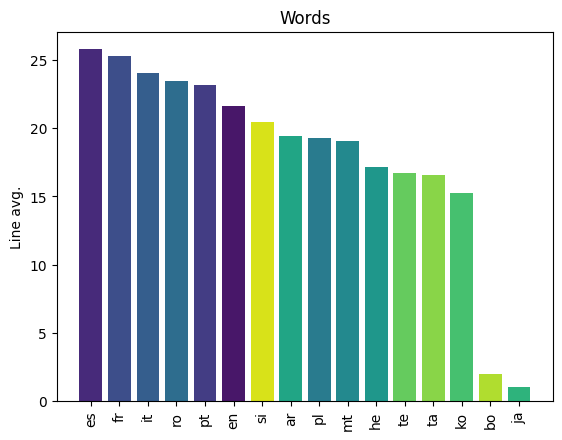

In [10]:
plot_token_numbers(flores_words, "Words")

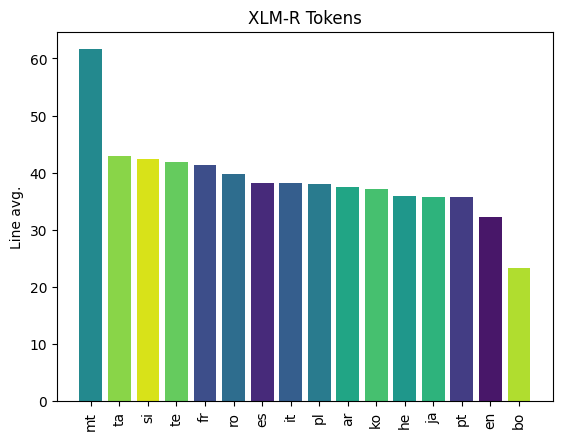

In [11]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

Tibetan: majority token UNK

In [12]:
sum([sum(3 == np.array(lt))/len(lt) for lt in flores_xlmr['bo']]) / len(flores_xlmr['bo'])

0.4361741061165873

## Balenced BBPE on FLORES

In [13]:
split="dev"
flores_tokenizers = build_gpt_tokenizer(f"flores200_dataset/{split}/joint.{split}", [10000, 50000,100000])
flores_il_tokenizers = {}
for lang in languages:
    flores_il_tokenizers[lang] = build_gpt_tokenizer(f"flores200_dataset/{split}/{languages_flores[lang]}.{split}", [2000, 10000,20000])


In [14]:
flores_baltok = {lang: [flores_tokenizers['tokenizer_50000'].encode(line) for line in flores[lang]] for lang in flores.keys()}
flores_il_baltok = {lang: [flores_il_tokenizers[lang]['tokenizer_10000'].encode(line) for line in flores[lang]] for lang in flores.keys()}

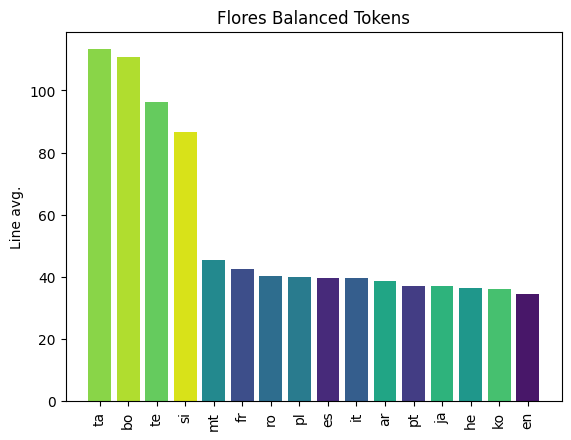

In [15]:
plot_token_numbers(flores_baltok, "Flores Balanced Tokens")

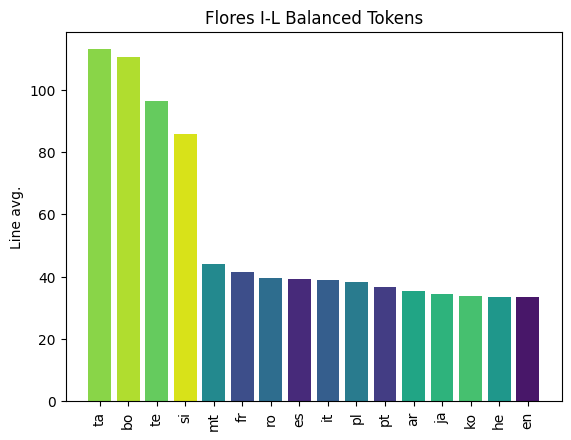

In [16]:
plot_token_numbers(flores_il_baltok, "Flores I-L Balanced Tokens")

## Morfessor experiments

In [17]:
def load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=False):
    flores_morfs = {}
    file_name= f"{split}_bp_{byte_patches}_ml_{morf_len}_mtn_{morf_type_num}"
    if joint:
        file_name = "joint_" + file_name
    for lang in languages:
        lang_fl = languages_flores[lang]
        path = f'morfessor_out/{lang_fl}/{file_name}.seg.decoded'
        try:
            with open(path, 'r') as f:
                flores_morfs[lang] = f.read().splitlines()
        except FileNotFoundError:
            print(f"File {path} not found")
            flores_morfs[lang] = [""]
    flores_morfs = {lang: [line.split() for line in flores_morfs[lang]] for lang in flores_morfs.keys()}

    return flores_morfs

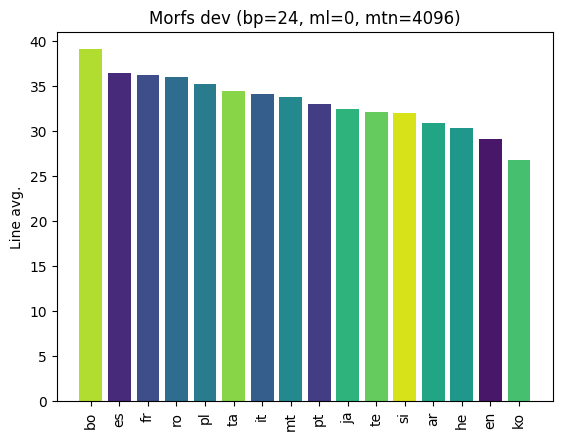

In [18]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs, title)

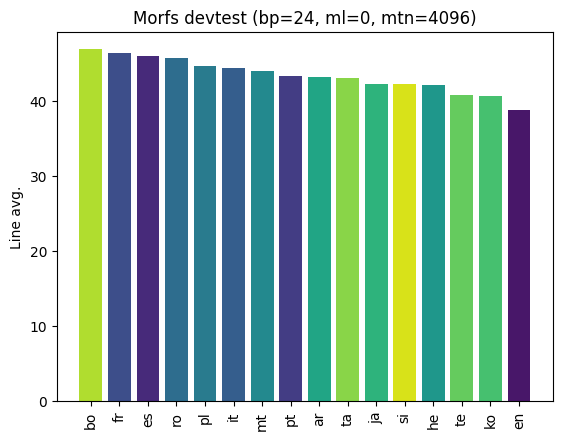

In [19]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs, title)

## Joint analysis

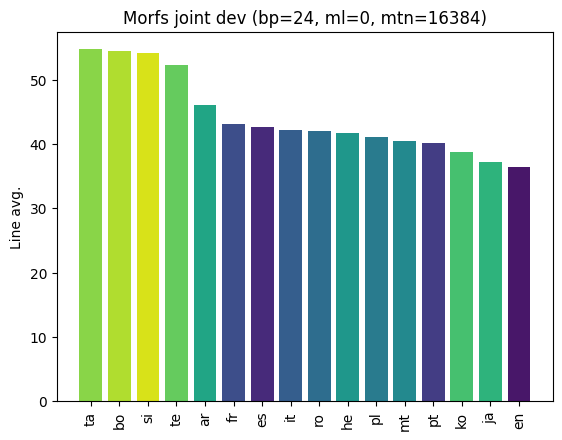

In [20]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

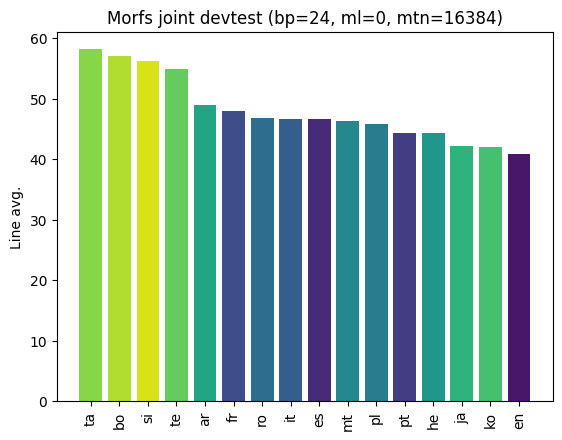

In [21]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

## Comparision of methods 

         bytes      morfs  morfs (joint)       chars     xlmr T  \
en  130.529644  38.785573      40.904150  130.401186  32.297431   
es  158.046443  45.994071      46.559289  155.178854  38.249012   
pt  145.769763  43.349802      44.337945  141.787549  35.687747   
fr  162.081028  46.407115      47.904150  155.818182  41.433794   
it  155.394269  44.383399      46.695652  154.286561  38.121542   
ro  155.099802  45.715415      46.721344  146.844862  39.695652   
pl  146.495059  44.689723      45.884387  137.831028  38.012846   
mt  151.973320  44.011858      46.234190  144.553360  61.596838   
he  180.910079  42.152174      44.242095  100.843874  35.961462   
ar  208.770751  43.193676      48.883399  114.940711  37.540514   
ja  165.127470  42.297431      42.240119   56.267787  35.748024   
ko  155.927866  40.670949      41.998024   65.182806  37.134387   
te  349.516798  40.866601      54.872530  130.933794  41.898221   
ta  416.641304  43.157115      58.147233  152.305336  42.86660

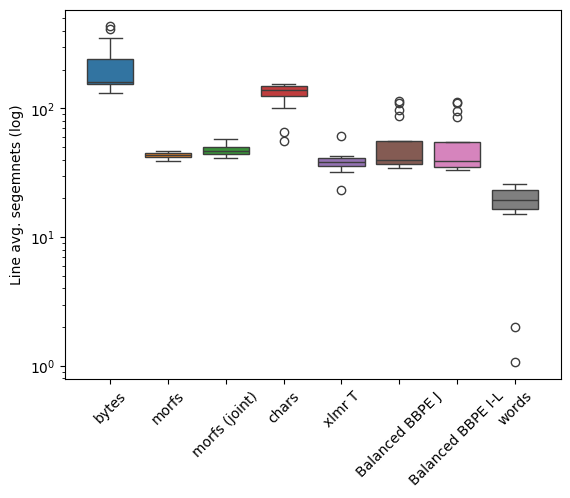

In [22]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_baltok,flores_il_baltok, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'Balanced BBPE J','Balanced BBPE I-L', 'words'])

       bytes     morfs  morfs (joint)     chars    xlmr T  Balanced BBPE J  \
en  1.000000  1.000000       1.000000  1.000000  1.000000         1.000000   
es  1.210809  1.185855       1.138253  1.190011  1.184274         1.154477   
pt  1.116756  1.117679       1.083947  1.087318  1.104972         1.074200   
fr  1.241718  1.196505       1.171132  1.194914  1.282882         1.235527   
it  1.190490  1.144328       1.141587  1.183168  1.180327         1.151238   
ro  1.188234  1.178671       1.142215  1.126101  1.229065         1.167001   
pl  1.122313  1.152225       1.121754  1.056977  1.176962         1.160639   
mt  1.164282  1.134748       1.130306  1.108528  1.907175         1.317580   
he  1.385969  1.086800       1.081604  0.773336  1.113447         1.059784   
ar  1.599413  1.113653       1.195072  0.881439  1.162337         1.119082   
ja  1.265057  1.090545       1.032661  0.431498  1.106838         1.071048   
ko  1.194578  1.048610       1.026742  0.499864  1.149763       

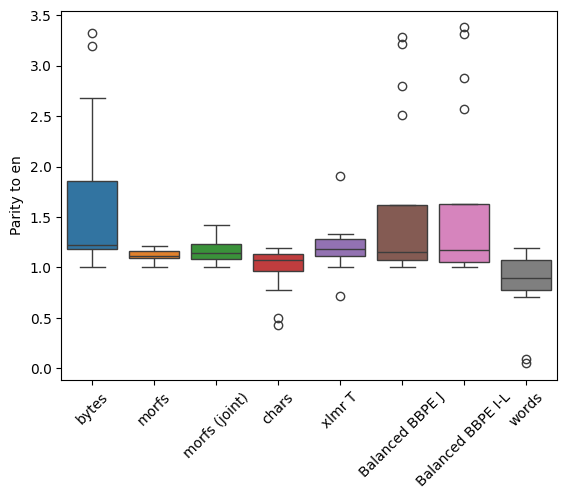

In [23]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_baltok, flores_il_baltok, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'Balanced BBPE J','Balanced BBPE I-L', 'words'], parity='en')